# Analyse the cause of steady state error

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control
from custom_functions.custom_functions import read_progress

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#### Plot rewards

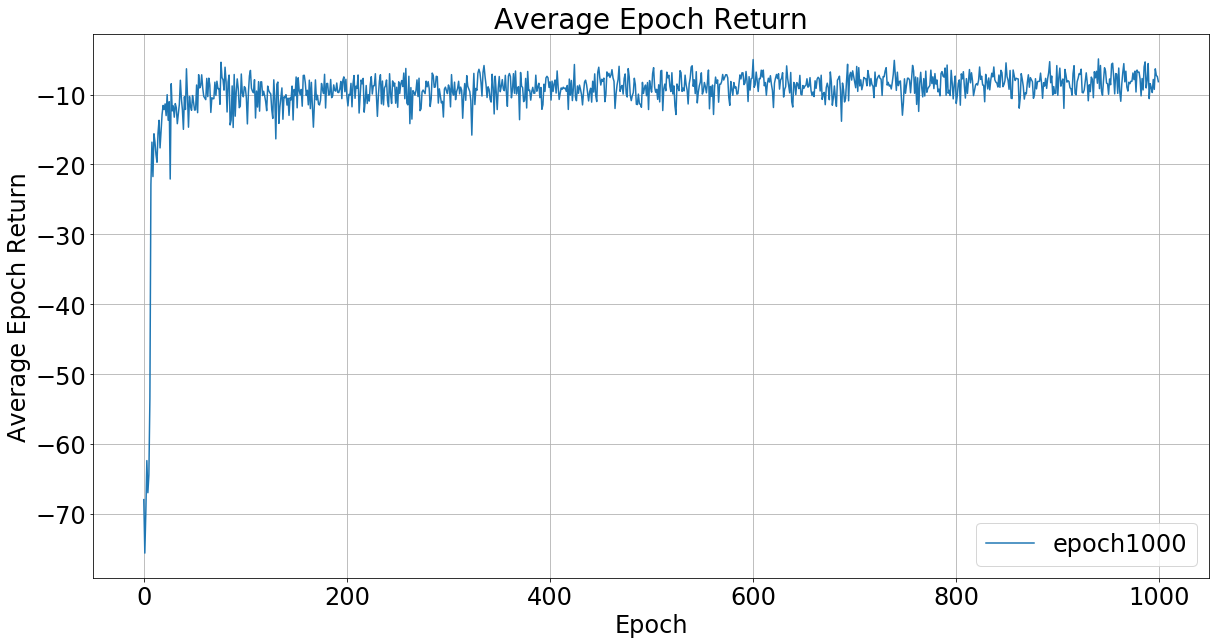

In [2]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['epoch1000']

for agent_path in agent_paths:
    progress = read_progress(agent_path)
    plt.plot(np.arange(progress.shape[0]), progress[:,1])
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
plt.legend(agent_paths,fontsize=24)

#### Test an agent

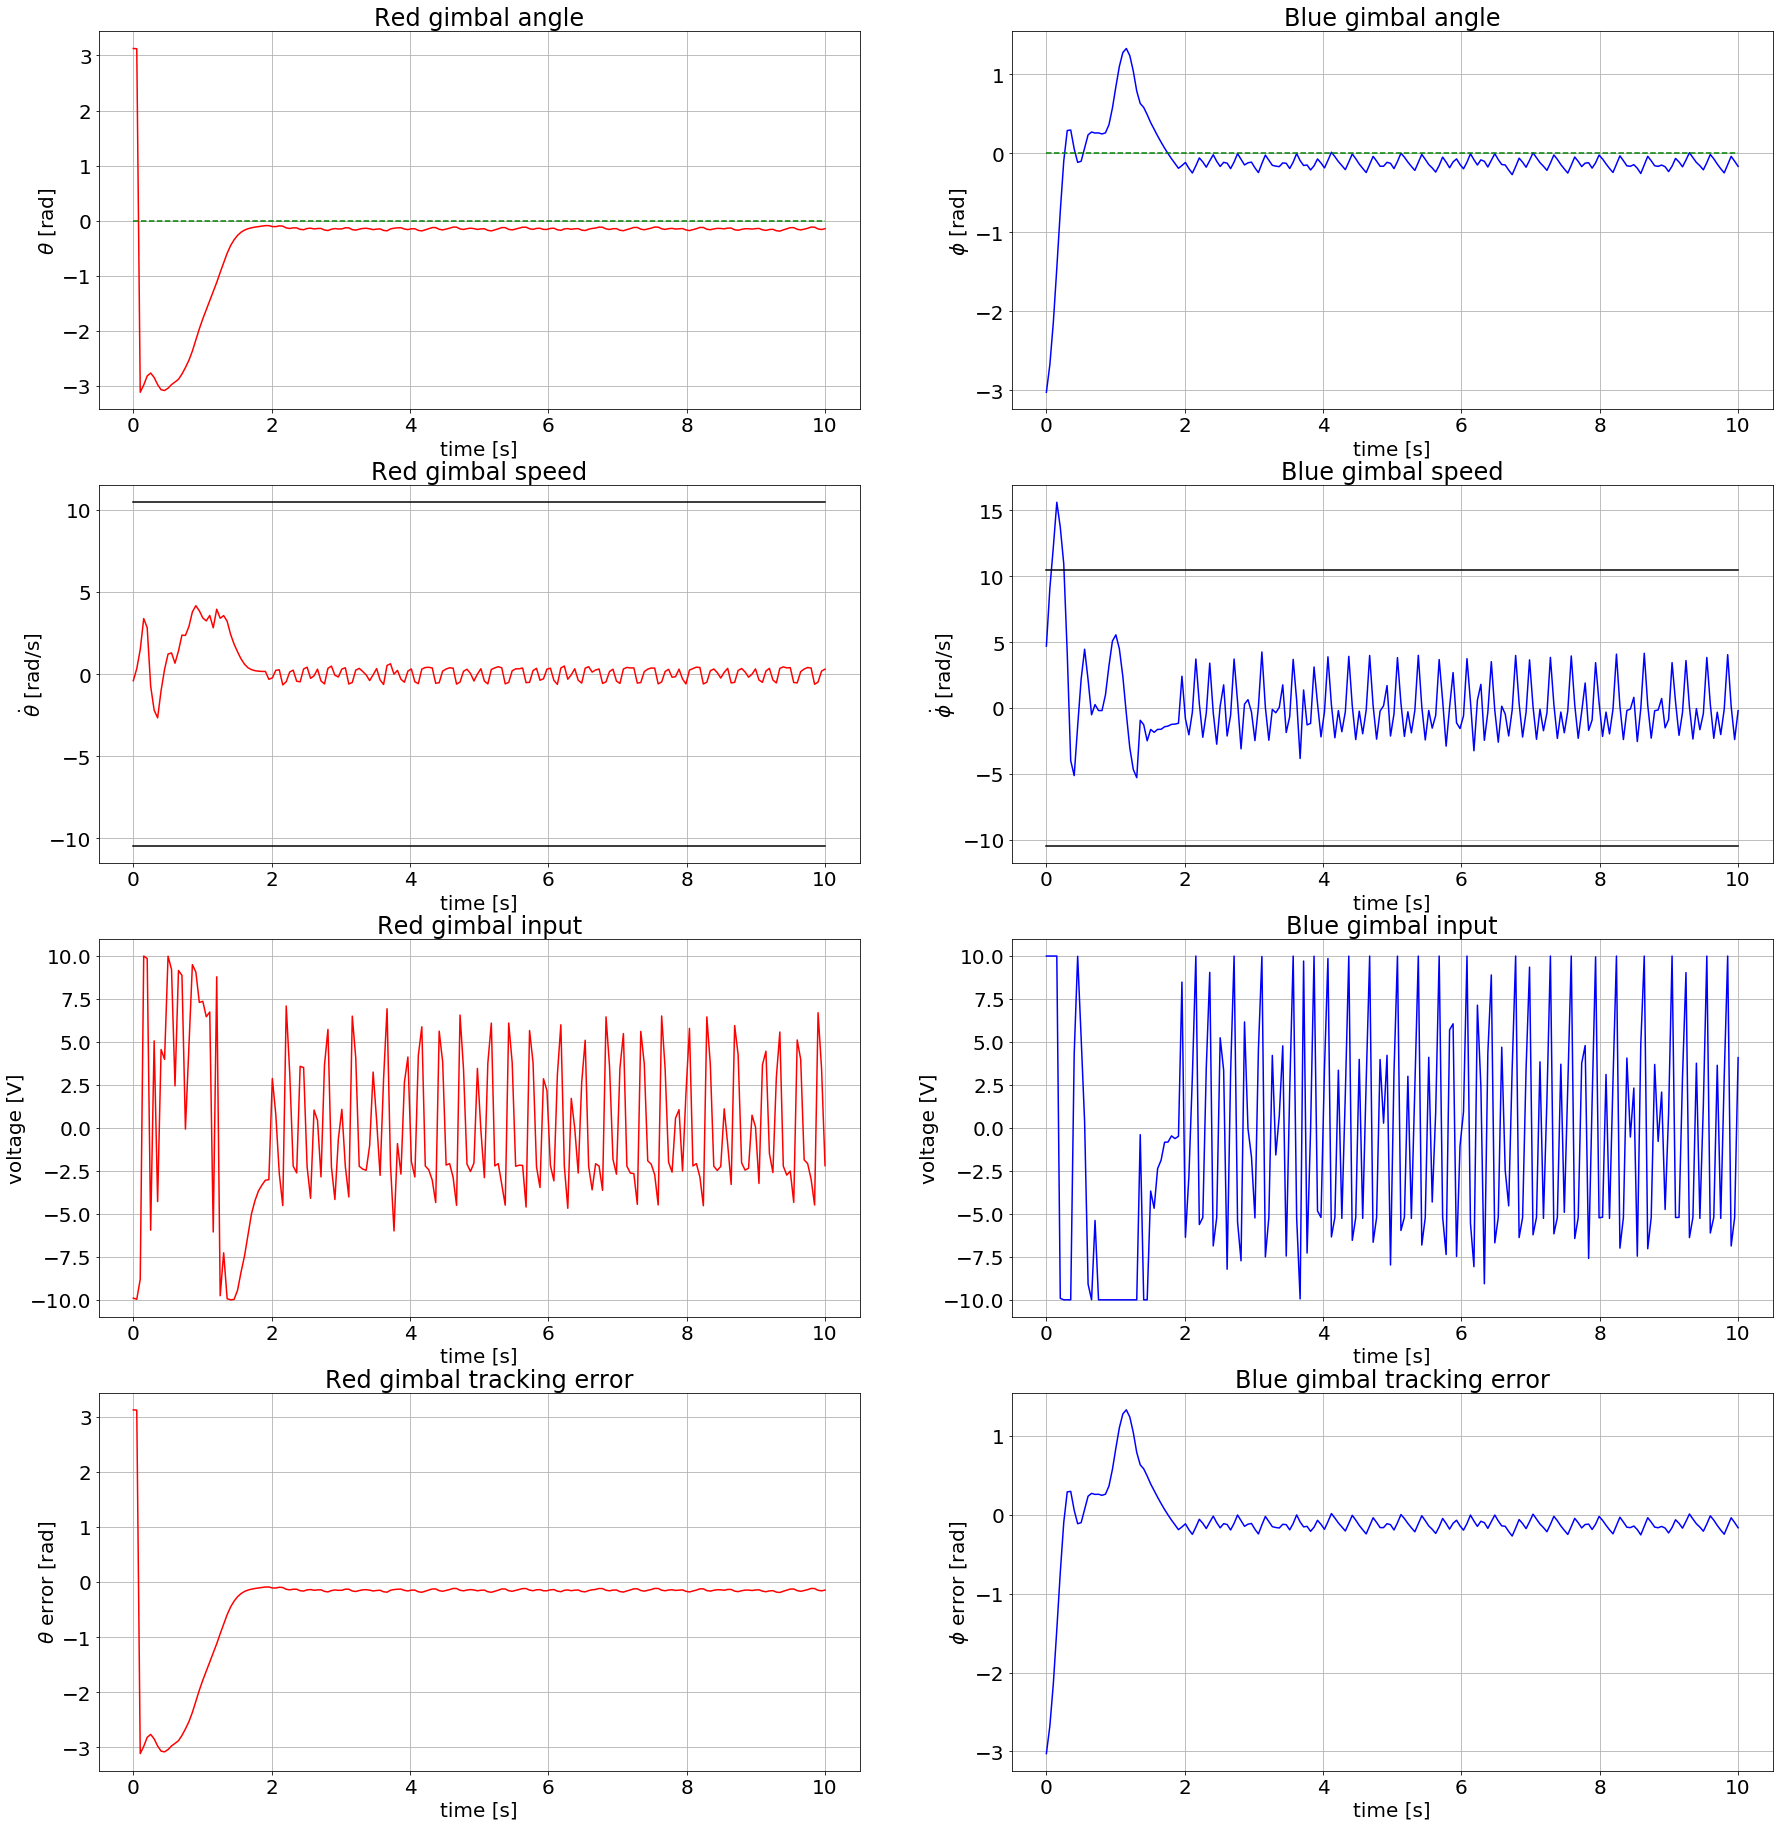

In [63]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'

init_state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
init_state = np.array([np.pi,0,np.pi,0,0,0,200/60*2*np.pi])

agent_paths = ['ddpg_q','ddpg_p01']
# Change this line to choose agent
agent_path = agent_paths[1]

if agent_path == 'ddpg_q':
    reward_func = 'Quadratic'
    reward_args = {
        'qx1': 1, 
        'qx2': 0, 
        'qx3': 1, 
        'qx4': 0, 
        'pu1': 0, 
        'pu2': 0
    }
else:
    reward_func = 'Power'
    reward_args = {
        'qx1': 1, 
        'qx2': 0, 
        'qx3': 1, 
        'qx4': 0, 
        'pu1': 0, 
        'pu2': 0,
        'p': 0.1
    }

env = create_env(env_name,reward_func=reward_func,reward_args=reward_args,state=init_state)

agent = load_agent(agent_path)
t_end = 10

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

In [37]:
# time = np.linspace(0, t_end, len(state_record))
# n = 1
# f, axs = plt.subplots(n,2,figsize=(30,8*n))

# plt.subplot(n,2,1)
# plt.title('Red gimbal angle',fontsize=24)
# plt.xlabel('time [s]',fontsize=20)
# plt.ylabel(r'$\theta$ [rad]',fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.grid()
# plt.plot(time,env.angle_normalize(state_record[:,0]),'r-')
# plt.plot(time,env.angle_normalize(state_record[:,4]),'g--')
# # plt.plot(time,np.full(len(time),180), 'k-')
# # plt.plot(time,np.full(len(time),-180), 'k-')

# plt.subplot(n,2,2)
# plt.title('Blue gimbal angle',fontsize=24)
# plt.xlabel('time [s]',fontsize=20)
# plt.ylabel(r'$\phi$ [rad]',fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.grid()
# plt.plot(time,env.angle_normalize(state_record[:,2]),'b-')
# plt.plot(time,env.angle_normalize(state_record[:,5]),'g--')
# # plt.plot(time,np.full(len(time),180), 'k-')
# # plt.plot(time,np.full(len(time),-180), 'k-')

# plt.savefig('emulation.png')

#### Evaluate control performance
#### The result shows the model is well-trained, so the ss error cannot be caused by unsufficient training

In [4]:
metrics_Q = pd.read_csv('Metrics_Q.csv')
metrics_Q

,Unnamed: 0,epoch100,epoch200,epoch300,epoch400,epoch500,epoch600,epoch700,epoch800,epoch900,epoch1000
0,$\theta$ MAE (rad),0.5206,0.5073,0.5074,0.5732,0.5310,0.5190,0.4895,0.4383,0.4266,0.4402
1,$\phi$ MAE (rad),0.3950,0.3743,0.3777,0.3168,0.3528,0.2838,0.3365,0.3842,0.4020,0.3172
2,$\theta$ MSSE (rad),0.4795,0.4651,0.4663,0.5383,0.4917,0.4723,0.4498,0.3899,0.3766,0.3988
3,$\phi$ MSSE (rad),0.3507,0.3340,0.3418,0.2779,0.3181,0.2430,0.2959,0.3491,0.3743,0.2746
4,$\theta$ in bounds (%),33.8200,31.9200,29.8600,27.5800,34.0400,33.0000,34.0900,35.9200,39.1200,37.0800
5,$\phi$ in bounds (%),45.3400,46.7400,41.0100,50.2100,45.1000,57.0900,51.6200,38.0100,37.0700,48.2700
6,$\theta$ unsteady (%),1.1400,1.0900,1.7600,1.0400,2.9100,2.3500,1.1700,5.7900,4.2500,3.8900
7,$\phi$ unsteady (%),3.0300,3.0800,4.5200,4.1900,5.5900,5.3400,4.2500,12.5600,11.0900,9.0800
8,$\theta$ rise time (s),0.6989,0.7018,0.7068,0.6855,0.7172,0.6882,0.6272,0.6019,0.6029,0.5610
9,$\phi$ rise time (s),0.4257,0.3703,0.3643,0.3864,0.4057,0.3776,0.3779,0.3477,0.3501,0.3657


/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Applications/Anaconda/anaconda3/envs/rl/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


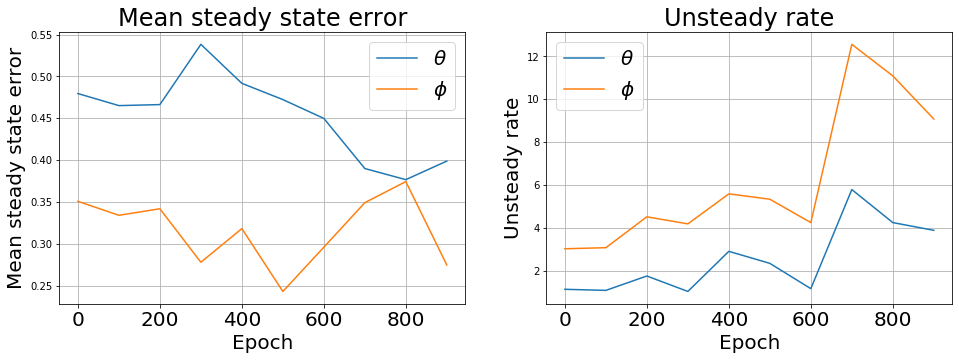

In [5]:
plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.plot([100*i for i in range(10)],metrics_Q.iloc[2,1:])
plt.plot([100*i for i in range(10)],metrics_Q.iloc[3,1:])
plt.title('Mean steady state error',fontsize=24)
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Mean steady state error',fontsize=20)
plt.grid()
plt.legend([r'$\theta$',r'$\phi$'],fontsize=20)

plt.subplot(1,2,2)
plt.plot([100*i for i in range(10)],metrics_Q.iloc[6,1:])
plt.plot([100*i for i in range(10)],metrics_Q.iloc[7,1:])
plt.title('Unsteady rate',fontsize=24)
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Unsteady rate',fontsize=20)
plt.grid()
plt.legend([r'$\theta$',r'$\phi$'],fontsize=20)

plt.savefig('ss_epoch.png')

#### The Q learning side of DDPG

In [58]:
path = agent_path + '/pyt_save/model.pt'
ac = torch.load(path)

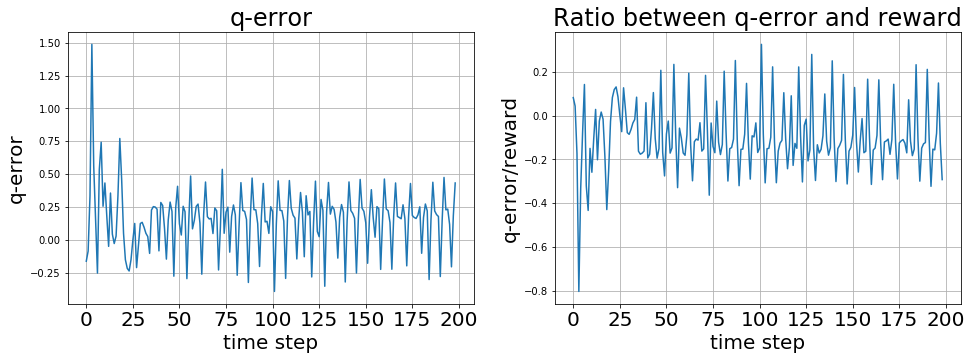

In [59]:
gamma = 0.995
es = np.zeros([len(obs_record)-1,1])
rs = np.zeros([len(obs_record)-1,1])
qs = np.zeros([len(obs_record)-1,1])
ys = np.zeros([len(obs_record)-1,1])
for i in range(len(obs_record)-1):
    o = torch.as_tensor(obs_record[i], dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2 = torch.as_tensor(obs_record[i+1], dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = reward_record[i+1] + gamma*q2
    es[i] = q - y
    rs[i] = reward_record[i+1]
    qs[i] = q
    ys[i] = y
# plt.plot(qs)
# plt.plot(ys)
# plt.plot(es/rs)
# plt.plot(es)


plt.subplots(1,2,figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(es)
plt.title('q-error',fontsize=24)
plt.xlabel('time step',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('q-error',fontsize=20)
plt.grid()

plt.subplot(1,2,2)
plt.plot(es/rs)
plt.title('Ratio between q-error and reward',fontsize=24)
plt.xlabel('time step',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('q-error/reward',fontsize=20)
plt.grid()

plt.savefig('p01_qerror.png')

In [29]:
gamma = 0.995
te = np.arange(-np.pi,np.pi,0.01)
e = np.zeros([len(te),1])
qs = np.zeros([len(te),1])
ys = np.zeros([len(te),1])
for i in range(len(te)):
    o = torch.as_tensor(env.reset([te[i],0,0,0,0,0,200/60*2*np.pi]), dtype=torch.float32)
    a = ac.pi(o)
    q = ac.q(o,a).detach().numpy()
    o2, r, _, _ = env.step(a.detach().numpy())
    o2 = torch.as_tensor(o2, dtype=torch.float32)
    a2 = ac.pi(o2)
    q2 = ac.q(o2,a2).detach().numpy()
    y = r + gamma*q2
    e[i] = q - y
    qs[i] = q
    ys[i] = y
# plt.scatter(te, qs)
# plt.plot(ys)
# plt.scatter(te, e)

#### Now we show that Q-value is not well trained in ddpg_q
#### More specifically, for state with low tracking error, their Q values are too close

In [25]:
path = 'ddpg_q/pyt_save/model.pt'
ac = torch.load(path)

In [26]:
env.reset([np.pi*1/2,0,np.pi*1/2,0,0,0,200/60*2*np.pi])
o_90 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/3,0,np.pi*1/3,0,0,0,200/60*2*np.pi])
o_60 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/6,0,np.pi*1/6,0,0,0,200/60*2*np.pi])
o_30 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([0,0,0,0,0,0,200/60*2*np.pi])
o_0 = torch.as_tensor(env.observation, dtype=torch.float32)

x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
X, Y = np.meshgrid(x, y)

q_90 = np.zeros([x.shape[0],y.shape[0]])
q_60 = np.zeros([x.shape[0],y.shape[0]])
q_30 = np.zeros([x.shape[0],y.shape[0]])
q_0 = np.zeros([x.shape[0],y.shape[0]])

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        a = torch.as_tensor([x[i], y[j]], dtype=torch.float32)
        q_90[i][j] = ac.q(o_90, a).detach().numpy()
        q_60[i][j] = ac.q(o_60, a).detach().numpy()
        q_30[i][j] = ac.q(o_30, a).detach().numpy()
        q_0[i][j] = ac.q(o_0, a).detach().numpy()

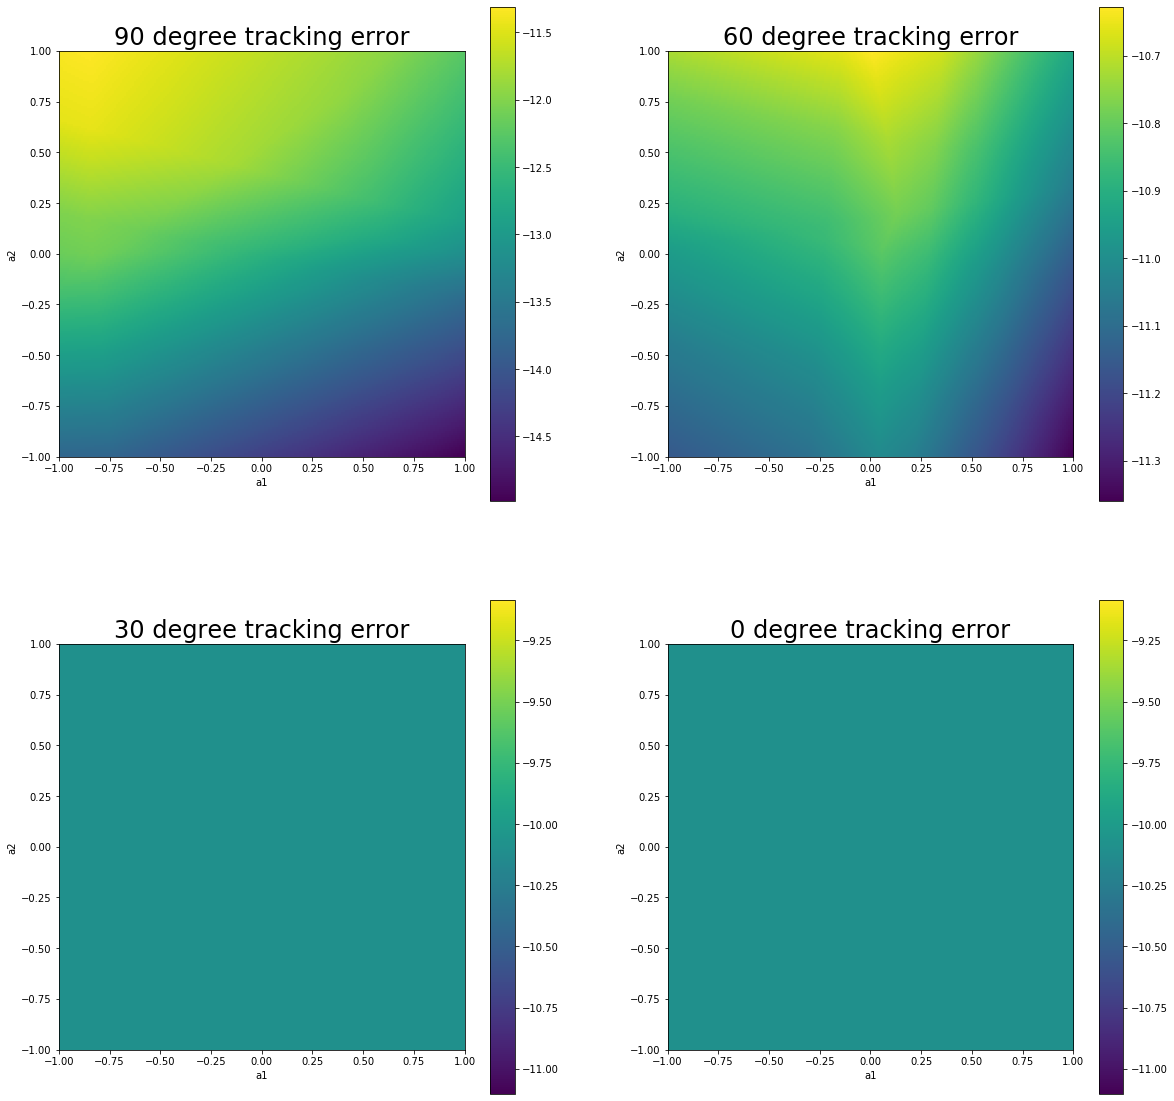

In [27]:
f, axs = plt.subplots(2,2,figsize=(20,20))
extent = [-1,1,-1,1]

plt.subplot(2,2,1)
plt.imshow(q_90,extent=extent)
plt.colorbar()
plt.title('90 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,2)
plt.imshow(q_60,extent=extent)
plt.colorbar()
plt.title('60 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,3)
plt.imshow(q_30,extent=extent)
plt.colorbar()
plt.title('30 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,4)
plt.imshow(q_0,extent=extent)
plt.colorbar()
plt.title('0 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

# plt.show()
plt.savefig('quad_qvalue.png')

#### Now we show the Q-value of ddpg_p01

In [60]:
path = 'ddpg_p01/pyt_save/model.pt'
ac = torch.load(path)

In [61]:
env.reset([np.pi*1/2,0,np.pi*1/2,0,0,0,200/60*2*np.pi])
o_90 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/3,0,np.pi*1/3,0,0,0,200/60*2*np.pi])
o_60 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([np.pi*1/6,0,np.pi*1/6,0,0,0,200/60*2*np.pi])
o_30 = torch.as_tensor(env.observation, dtype=torch.float32)
env.reset([0,0,0,0,0,0,200/60*2*np.pi])
o_0 = torch.as_tensor(env.observation, dtype=torch.float32)

x = np.arange(-1,1,0.01)
y = np.arange(-1,1,0.01)
q_90 = np.zeros([x.shape[0],y.shape[0]])
q_60 = np.zeros([x.shape[0],y.shape[0]])
q_30 = np.zeros([x.shape[0],y.shape[0]])
q_0 = np.zeros([x.shape[0],y.shape[0]])

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        a = torch.as_tensor([x[i], y[j]], dtype=torch.float32)
        q_90[i][j] = ac.q(o_90, a).detach().numpy()
        q_60[i][j] = ac.q(o_60, a).detach().numpy()
        q_30[i][j] = ac.q(o_30, a).detach().numpy()
        q_0[i][j] = ac.q(o_0, a).detach().numpy()

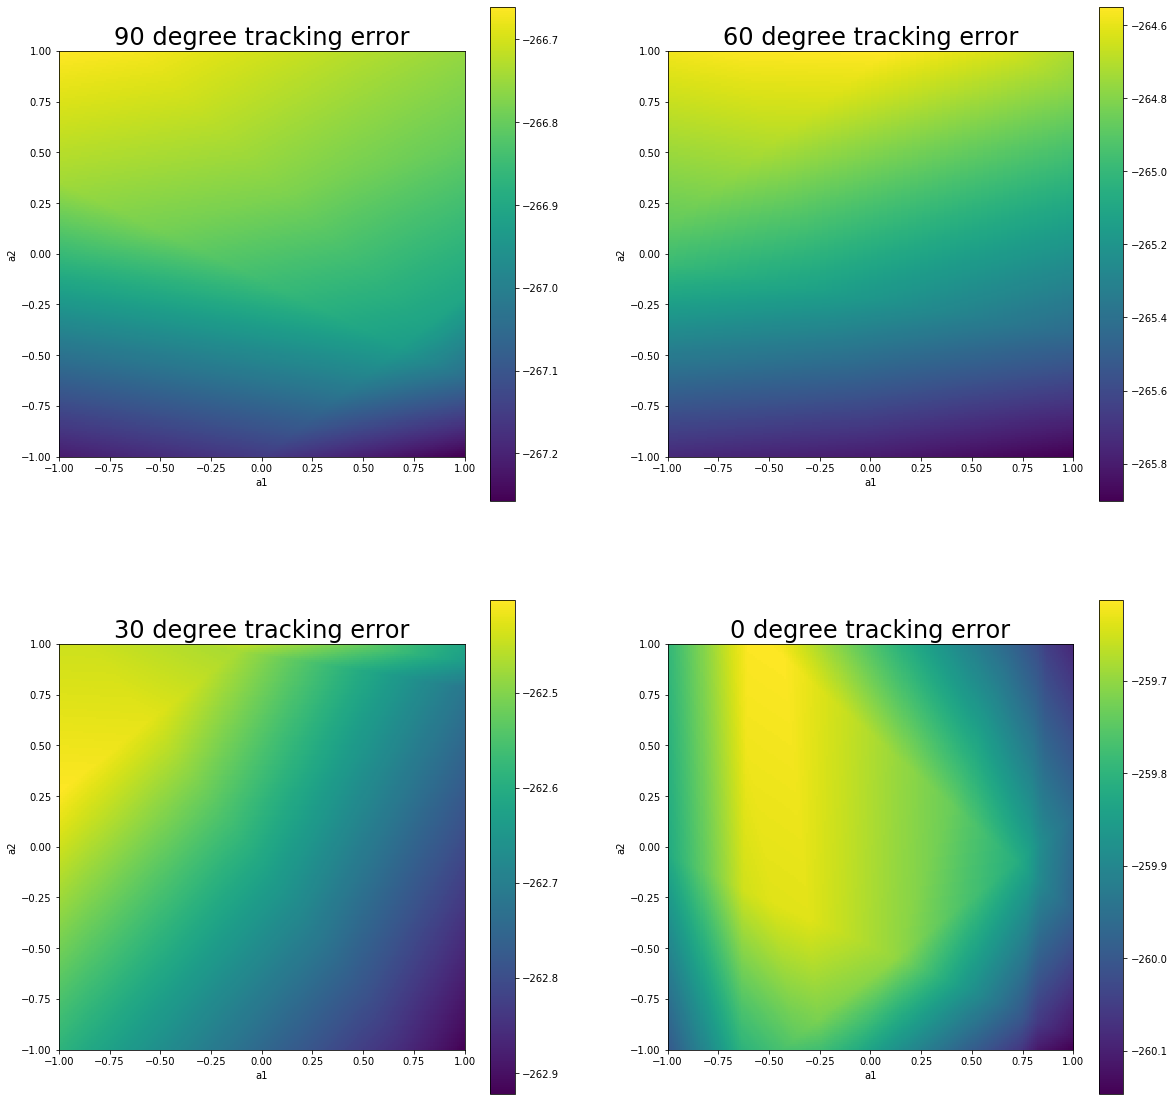

In [62]:
f, axs = plt.subplots(2,2,figsize=(20,20))
extent = [-1,1,-1,1]

plt.subplot(2,2,1)
plt.imshow(q_90,extent=extent)
plt.colorbar()
plt.title('90 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,2)
plt.imshow(q_60,extent=extent)
plt.colorbar()
plt.title('60 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,3)
plt.imshow(q_30,extent=extent)
plt.colorbar()
plt.title('30 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

plt.subplot(2,2,4)
plt.imshow(q_0,extent=extent)
plt.colorbar()
plt.title('0 degree tracking error',fontsize=24)
plt.xlabel('a1')
plt.ylabel('a2')

# plt.show()
plt.savefig('p01_qvalue.png')